# Временное кодирование спайковых нейронных сетях
Здесь на простом примере показано, как работает обучение без учителя в сочетании с временным кодированием. 
* генерация обучающих примеров
* создание сети
* обучение сети по правилу STDP
* назначение классов нейронам и оценка качества

## Задание
Дополнение в лабораторную работу №2:
* Научить сеть распознавать три класса периодических сигналов на отрезке $x\in[0,1]$:
$$
f_{k}(x)=a_{k}\sin(b_kx)
$$
Дискретизация сигнала равна 20 точек на отрезке.

In [ ]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 4.4 MB/s 
     |████████████████████████████████| 965 kB 36.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import brian2 as b2

## Генерация данных
* Сгенерируем эталонные картинки - образцы классов
* Сгенерируем набор зашумленных картинок
* Разобьем на обучающую и тестовую выборки

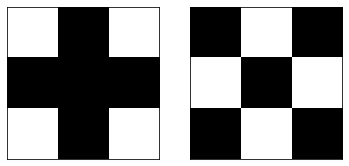

In [ ]:
def draw_patterns(patterns, figsize=(6,4)):
  fig, ax = plt.subplots(nrows = 1, ncols = len(patterns), figsize=figsize)
  for i,p in enumerate(patterns):
    ax[i].imshow(patterns[i], cmap='Greys')
    ax[i].tick_params(axis='both', labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                             bottom=False, top=False, left=False, right=False)
plus = np.array([0, 1, 0,
                 1, 1, 1,
                 0, 1, 0]).reshape(3,3)
cross = np.array([1, 0, 1,
                  0, 1, 0,
                  1, 0, 1]).reshape(3,3)
patterns = [plus, cross]
draw_patterns(patterns)

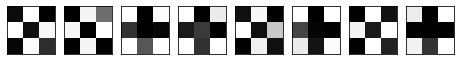

In [ ]:
from sklearn.model_selection import train_test_split
N_SAMPLE_CLASS = 30
rng = np.random.default_rng()
X,y = [],[]
sigma = 0.15
for i_p,p in enumerate(patterns):
  for _ in range(N_SAMPLE_CLASS):
    X += [np.clip(p + sigma*rng.standard_normal(p.shape),0,1)]
    y += [i_p]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
draw_patterns(X_train[-8:], figsize=(8,5))

# Временное кодирование
Чем больше яркость пикселя $r_i$, тем быстрее наступит спайк
1. Обратная зависимость
$$t_i=1/r_i$$
Если $r_i=0$, то этот нейрон не спайкует
2. Линейное убывание от максимального значения на интервале $[t_{min}, t_{max}]$
$$t_i=t_{max}-r_i\frac{t_{min}}{t_{max}-t_{min}}$$

## Создаем сеть
* Входной слой, кол-во нейронов равно кол-ву пикселей
* Выходной слой, кол-во нейронов должно быть не меньше кол-ва классов
* STDP синапсы
* Синапсы латерального торможения

In [ ]:
#These parameters must be in the global namespace area
taum = 10*b2.ms
taue = 5*b2.ms
taui = 10*b2.ms
v_rest = -74*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
Ee = 0*b2.mV
Ei = -100*b2.mV

def create_input(size):
  input_group = b2.SpikeGeneratorGroup(size, indices = [],
                                       times=[]*b2.ms, name='SG')  
  s_mon_inp = b2.SpikeMonitor(input_group)
  return input_group, s_mon_inp

def create_exc_neurons(size):
  neuron_eq = '''
            dv/dt = (v_rest - v + ge * (Ee - v) + gi * (Ei - v)) / taum : volt
            dge/dt = -ge / taue : 1
            dgi/dt = -gi / taui : 1
            '''
  neurons = b2.NeuronGroup(size, neuron_eq, threshold='v>vt', reset='v = vr',
                      method='euler')
  neurons.v = v_rest
  neurons.ge=0
  neurons.gi=0
  s_mon_nrn = b2.SpikeMonitor(neurons)
  return neurons, s_mon_nrn

taupre=20*b2.ms
taupost=20*b2.ms
gmax=0.5
gi_max = gmax
max_delay_i = 10*b2.ms
dApre=0.01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

def create_stdp_synapses(pre_group, post_group):
  S = b2.Synapses(pre_group, post_group,
             '''w : 1
                stdp_rate : 1 (shared)
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + stdp_rate*Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + stdp_rate*Apre, 0, gmax)''',
             )
  S.connect()
  S.w = 'rand() * gmax'
  S.stdp_rate = 1
  mon = b2.StateMonitor(S, 'w', record=True)
  return S, mon

def create_inh_synapses(neuron_group):
  S = b2.Synapses(neuron_group, neuron_group,
             '''w : 1
                ''',
             on_pre='''gi += w''',
             )
  S.connect('i!=j')
  S.delay = "max_delay_i*rand()"
  S.w = gi_max  
  return S


In [ ]:
b2.start_scope()
input_layer, mon_input = create_input(patterns[0].size)
exc_layer, mon_exc = create_exc_neurons(5*len(patterns))
stdp_synapses, mon_stdp = create_stdp_synapses(input_layer, exc_layer)
inh_synapses = create_inh_synapses(exc_layer)
b2.run(0*b2.ms)
b2.store() # store the initialized fresh network 

Input layer: 9 neurons
Excitatory layer: 10 neurons
90 STDP synapses
90 inhibitory synapses


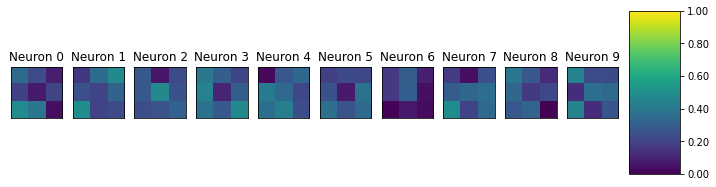

In [ ]:
def plot_synapses(n_source, n_target, synapses, title=""):
  plt.figure(figsize=(3,3))
  W = np.full((n_source, n_target), np.nan)
  W[synapses.i[:], synapses.j[:]] = synapses.w[:]
  plt.imshow(W)
  plt.yticks(synapses.i)
  plt.xticks(synapses.j)
  plt.title(title)
  plt.xlabel("Target")
  plt.ylabel("Source")
  plt.colorbar(format="%4.2f")

def plot_input_synapses(synapses):
  #plt.figure(figsize=(16,5))
  fig,ax = plt.subplots(nrows=1, ncols=len(synapses.target)+1, figsize=(12,3))
  for j in range(len(synapses.target)):
    #W = np.full((3, 3), np.nan)
    #W[:, :] = 
    im = ax[j].imshow(np.reshape(synapses.w[:,j], (3,3)), vmin=0, vmax=1)
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].set_title(f"Neuron {j}")
  fig.colorbar(im, cax = ax[-1], format="%4.2f")

print(f"Input layer: {len(input_layer)} neurons")
print(f"Excitatory layer: {len(exc_layer)} neurons")
print(f"{len(stdp_synapses)} STDP synapses")
print(f"{len(inh_synapses)} inhibitory synapses")
#plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")
#plot_synapses(exc_layer.N, exc_layer.N, inh_synapses, "Inhibitory weights")
plot_input_synapses(stdp_synapses)


## Обучение сети
Последовательно предъявляем все образы из обучающей выборки. Каждый образ предъявляется в течение T=150 мс. 

In [ ]:
arr = np.ones((X_train[0].size,))/X_train[0].ravel()
arr[arr==np.inf] = 0
print(arr)

WARNING    /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
 [py.warnings]
  """Entry point for launching an IPython kernel.



[0.         1.         8.13142436 1.1164446  1.21679265 1.
 0.         1.         0.        ]


WARNING    /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
 [py.warnings]
  if __name__ == '__main__':



Training STDP weights has finished!


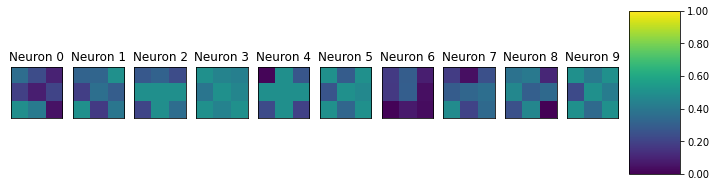

In [ ]:
INF_TIME = 1000
t_min = 0.01*b2.ms
T_img = 50*b2.ms
T_rest = 30*b2.ms

indices = list(range(len(input_layer)))

def encode_ttfs_inverse(img):
  times = np.ones((img.size,))/img.ravel()
  times[times==np.inf] = INF_TIME
  return np.ones((img.size,))*t_min + times*b2.ms
def encode_ttfs_linear(img):
  #Your code here
  pass

def train(X):
  total_time = 0*b2.ms
  for img in X:
    times = total_time + encode_ttfs_inverse(img)
    input_layer.set_spikes(indices, times)
    b2.run(T_img, report=None)
    total_time += T_img
    input_layer.set_spikes([], []*b2.ms)
    b2.run(T_rest, report=None)
    total_time += T_rest
  return total_time

b2.restore()
stdp_synapses.stdp_rate = 1
total_time = train(X)
print("Training STDP weights has finished!")
plot_input_synapses(stdp_synapses)

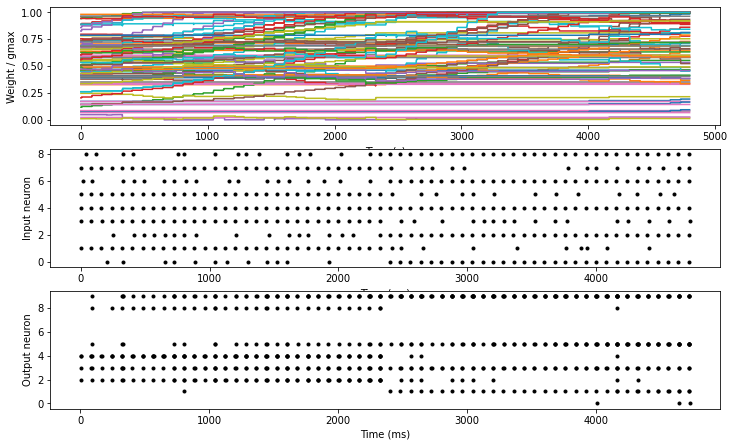

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(mon_stdp.t/b2.ms, mon_stdp.w.T/gmax)
plt.xlabel('Time (s)')
plt.ylabel('Weight / gmax')
plt.subplot(412)
plt.plot(mon_input.t/b2.ms, mon_input.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Input neuron')
#plt.yticks(range(0,len(input_rates)))
plt.subplot(413)
plt.plot(mon_exc.t/b2.ms, mon_exc.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Output neuron')
#plt.tight_layout()
plt.show()
#plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")

## Назначаем классы нейронам
Предъявляем сети по очереди изображения. Для каждого изображения подсчитываем количество спайков от каждого нейрона и сохраняем в массив.
Затем каждому нейрону назначаем класс в зависимости от того, на какой класс изображений он был больше всего активен.

WARNING    /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
 [py.warnings]
  if __name__ == '__main__':



[1 1 0 0 0 1 0 0 0 1]
[[0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 1. 3. 3. 4. 4. 0. 0. 3. 5.]
 [1. 2. 0. 2. 0. 6. 0. 0. 0. 5.]
 [0. 0. 4. 2. 4. 4. 0. 0. 2. 5.]
 [0. 1. 3. 3. 4. 4. 0. 0. 2. 5.]
 [1. 2. 0. 2. 0. 5. 0. 0. 0. 4.]
 [1. 2. 0. 2. 0. 5. 0. 0. 0. 5.]
 [0. 2. 0. 2. 0. 5. 0. 0. 0. 4.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 3.]
 [0. 2. 0. 2. 0. 4. 0. 0. 0. 4.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 3.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 0. 3. 2. 4. 3. 0. 0. 2. 3.]
 [0. 2. 0. 2. 0. 5. 0. 0. 0. 4.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 2. 0. 2. 0. 4. 0. 0. 0. 4.]
 [1. 2. 0. 2. 0. 5. 0. 0. 0. 4.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 2. 0. 2. 0. 4. 0. 0. 0. 4.]
 [0. 2. 0. 2. 0. 4. 0. 0. 0. 4.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 0. 4. 3. 4. 4. 0. 0. 2. 4.]
 [0. 2. 0. 2. 0. 4. 0. 0. 0. 4.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 2. 0. 2. 0. 4. 0. 0. 0. 4.]
 [0. 0. 3. 2. 3. 2. 0

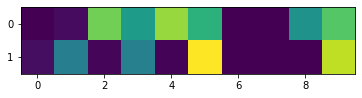

In [ ]:
def evaluate(X, total_time):
  img_spike_count = np.zeros((len(X), len(exc_layer)))
  T_show = 50*b2.ms
  rate_mon = b2.SpikeMonitor(exc_layer)
  prev_count = np.zeros((len(exc_layer),))
  for i_img, img in enumerate(X):
    times = total_time + encode_ttfs_inverse(img)
    input_layer.set_spikes(indices, times)
    b2.run(T_show, report=None)
    total_time += T_show
    img_spike_count[i_img,:] = np.array(rate_mon.count-prev_count)
    prev_count += img_spike_count[i_img,:]
    input_layer.set_spikes([], []*b2.ms)
    b2.run(T_rest, report=None)
    total_time += T_rest
    #del rate_mon
  return img_spike_count, total_time
  
stdp_synapses.stdp_rate = 0
train_rates, total_time = evaluate(X_train, total_time)
nrn_class_count = np.zeros((len(patterns),len(exc_layer)))
for i_class in range(len(patterns)):
  nrn_class_count[i_class,:] = np.sum(train_rates[np.equal(y_train,i_class),:], axis=0)
plt.imshow(nrn_class_count)  
neuron_class = np.argmax(nrn_class_count, axis=0)
print(neuron_class)
print(train_rates)

## Оценка точности классификации на тестовой выборке

In [ ]:
test_rates, total_time = evaluate(X_test, total_time)
print(test_rates)

WARNING    /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
 [py.warnings]
  if __name__ == '__main__':



[[0. 2. 0. 2. 0. 4. 0. 0. 0. 4.]
 [0. 0. 3. 2. 4. 4. 0. 0. 2. 5.]
 [1. 2. 0. 2. 0. 5. 0. 0. 0. 4.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]
 [0. 0. 4. 2. 4. 3. 0. 0. 2. 4.]
 [0. 2. 0. 2. 0. 4. 0. 0. 0. 4.]
 [1. 2. 0. 2. 0. 6. 0. 0. 0. 4.]
 [0. 2. 1. 3. 1. 6. 0. 0. 1. 5.]
 [0. 2. 0. 2. 0. 5. 0. 0. 0. 4.]
 [1. 2. 0. 2. 0. 5. 0. 0. 0. 4.]
 [0. 2. 0. 2. 0. 4. 0. 0. 0. 4.]
 [0. 0. 3. 2. 3. 2. 0. 0. 2. 2.]]


[1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]
Accuracy: 0.9166666666666666


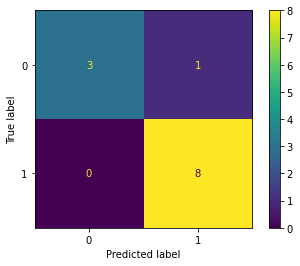

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

def predict(rates, neuron_class):
  y = np.ones(rates.shape[0])*np.nan
  for i,x in enumerate(rates):
    y[i] = neuron_class[np.argmax(x)]
  return y

test_prediction = predict(test_rates, neuron_class)

print(test_prediction)
print(y_test)
acc = accuracy_score(y_test, test_prediction)
cm = confusion_matrix(y_test, test_prediction)
print(f"Accuracy: {acc}")
cm_display = ConfusionMatrixDisplay(cm).plot()
